In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

实验设计：
- 从 Visium 删除一部分 spot，这些 spot 作为验证集。
- 将 dropped Visium 输入 iStar 进行超分，采用 Image 模式 8um super pixel size
- 将验证集 spot 所覆盖的像素加和作为预测值
- 计算 pcc, mse

In [2]:
from datasets import VisiumData
from models import iStar
from pathlib import Path
from profiles import VisiumProfile
import imageio.v2 as ii
import cv2
import random
import matplotlib.pyplot as plt

### 数据准备
DLPFC

In [3]:
visium_path = Path('/home/yiriso/Research/Super-resolvedST/data/DLPFC/sample_151673')
raw_visium = VisiumData()
visium_profile = VisiumProfile(slide_serial=1)
raw_visium.load(
    path=visium_path,
    profile=visium_profile,
    source_image_path=visium_path/"151673_full_image.tif"
)
raw_visium.select_HVG(n_top_genes=2000,min_counts=10)

Start load
Finish load in 0.4412 s


随机删除 spot

In [4]:
drop_ids = random.sample(range(len(visium_profile)), 1000)
dropped_visium = raw_visium.drop_spots(spot_ids=drop_ids)

738 spots will be dropped.


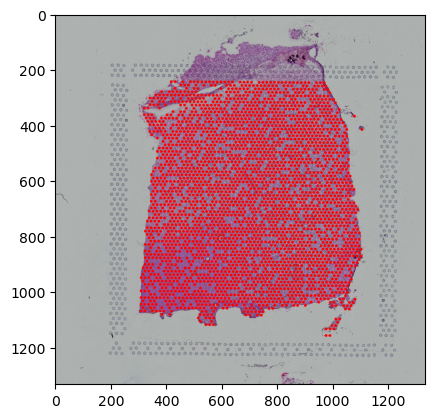

In [5]:
spot_img = dropped_visium.vision_spots(in_tissue=True)
plt.imshow(cv2.resize(spot_img, None, fx=0.1, fy=0.1))

将删除 spot 的数据保存

In [6]:
dropped_visium.save("DLPFC_dropped")

Start save
Finish save in 1.3274 s


/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/utility.py:168: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['feature_type'] = 'Gene Expression'


### 使用 iStar 超分

In [8]:
istar_visium = iStar()
istar_visium.load(
    path="DLPFC_dropped",
    profile=visium_profile,
    source_image_path=visium_path/"151673_full_image.tif"
)
istar_visium.tissue_mask(mask_image_path=visium_path/"mask.png")
istar_visium.set_super_pixel_size(8)
istar_visium.save_input("istar_on_dropped")

Start load
Finish load in 0.1660 s


bash 运行 iStar 工具 

In [10]:
istar_visium.load_output("istar_on_dropped")
istar_visium.to_h5ad()

Reading iStar output
[██████████████████████████████████████████████████] 100.00%
Start to_h5ad


/home/yiriso/anaconda3/envs/DataReader/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Finish to_h5ad in 4.3440 s


### 